# Сегментация цветных изображений с дрона с использованием Feature Pyramid Networks (FPN)

## Подключение библиотек

In [1]:
import glob # Модуль glob находит все имена путей, соответствующие заданному шаблону

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchsummary import summary

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import segmentation_models_pytorch as smp

import torchvision
from torchvision import models 

import cv2

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150
from PIL import Image
import torchvision.transforms as T 

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import tqdm.notebook as tq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Создание класса датасета (входное изображение - целевая разметка)

In [2]:
class CustomDataset(Dataset):
    def __init__(self):
        images_path = './dataset/semantic_drone_dataset/original_images/*'
        labels_path = './dataset/semantic_drone_dataset/label_images_semantic/*'
        
        self.fileListRGB = sorted(glob.glob(images_path)) 
        self.fileListLabel = sorted(glob.glob(labels_path))
        
        self.trf = T.Compose([T.ToPILImage(), T.Resize(256), T.CenterCrop(224), T.ToTensor()])#, 
#                  T.Normalize(mean = [0.485, 0.456, 0.406], 
#                              std = [0.229, 0.224, 0.225])]) 
        
        self.trf_sem = T.Compose([T.ToPILImage(), T.Resize(256), T.CenterCrop(224), T.ToTensor()])

    # функция, которая возвращает длину набора данных
    def __len__(self):
        return len(self.fileListRGB)

    # функция, которая возвращает один обучающий пример
    def __getitem__(self, idx):
        return self.fileListRGB[idx], self.fileListLabel[idx]

    def getImgsTensors(self, imgs_path, lbls_path):
        output_tensor_rgb = torch.tensor([], dtype=torch.float)
        output_tensor_lbl = torch.tensor([], dtype=torch.float)

        for img_path, lbl_path in zip(imgs_path, lbls_path):
            img = cv2.imread(img_path)
            img_tensor = self.trf(img).unsqueeze(0)
            output_tensor_rgb = torch.cat((output_tensor_rgb, img_tensor))
            
            lbl = cv2.imread(lbl_path, cv2.IMREAD_GRAYSCALE)
            lbl_tensor = self.trf_sem(lbl).unsqueeze(0)
            output_tensor_lbl = torch.cat((output_tensor_lbl, lbl_tensor))

        return output_tensor_rgb, output_tensor_lbl
    
    def getClassFromIndex(self, idx):
#         if idx >= len(self.labels): 
#             return 0

#         return self.computedClassesFromIndex[idx]
        pass

## Разбиение набора данных на тренировочную, валидационную и тестовую выборки

In [3]:
dataset = CustomDataset()
dataset_train_test, dataset_val = train_test_split(dataset, test_size=0.2)
dataset_train, dataset_test = train_test_split(dataset_train_test, test_size=0.1)

trainDataLoader = DataLoader(dataset_train, batch_size=4, shuffle=True)
testDataLoader = DataLoader(dataset_test, batch_size=4, shuffle=True)
valDataLoader = DataLoader(dataset_val, batch_size=4, shuffle=True)

print('Train Size   : ', len(trainDataLoader))
print('Val Size    : ', len(valDataLoader))
print('Test Size     : ', len(testDataLoader))

Train Size   :  72
Val Size    :  20
Test Size     :  8


## Примеры картинок из датасета

torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224])


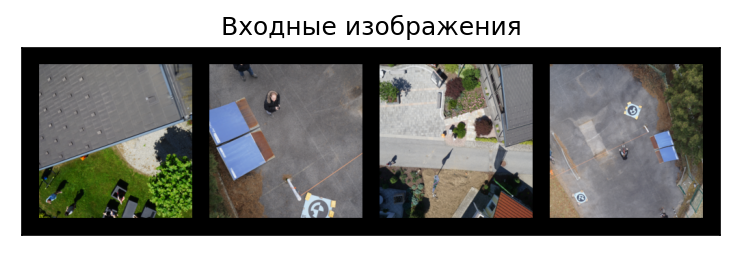

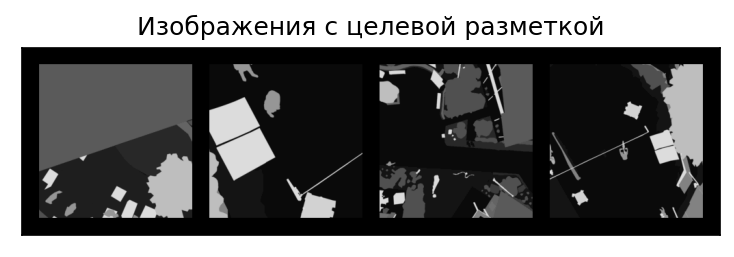

In [30]:
test_features, test_labels = next(iter(testDataLoader))
test_features, test_labels = dataset.getImgsTensors(test_features, test_labels)

print(test_features.shape, test_labels.shape)

# Вывод примера данных - цветное изображения
gridImgs = torchvision.utils.make_grid(test_features, padding=25)
plt.imshow(cv2.cvtColor(gridImgs.permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.title("Входные изображения")
plt.show()

# Вывод примера данных - метки изображений
gridImgs = torchvision.utils.make_grid(test_labels, padding=25)
plt.imshow(gridImgs.permute(1, 2, 0)*10)
plt.xticks([])
plt.yticks([])
plt.title("Изображения с целевой разметкой")
plt.show()

## Построение модели Feature Pyramid Networks и вывод информации о ней

In [5]:
!pip3 install torchinfo
import torchinfo

model = smp.FPN('mobilenet_v2', in_channels=3, classes=24).to(device)
print(torchinfo.summary(model, input_size=(4, 3, 224, 224)))
model = model.train()

Layer (type:depth-idx)                                  Output Shape              Param #
FPN                                                     --                        --
├─FPNDecoder: 1                                         --                        --
│    └─ModuleList: 2-1                                  --                        --
├─MobileNetV2Encoder: 1-1                               [4, 3, 224, 224]          --
│    └─Sequential: 2                                    --                        --
│    │    └─ConvNormActivation: 3-1                     [4, 32, 112, 112]         928
│    │    └─InvertedResidual: 3-2                       [4, 16, 112, 112]         896
│    │    └─InvertedResidual: 3-3                       [4, 24, 56, 56]           5,136
│    │    └─InvertedResidual: 3-4                       [4, 24, 56, 56]           8,832
│    │    └─InvertedResidual: 3-5                       [4, 32, 28, 28]           10,000
│    │    └─InvertedResidual: 3-6               

## Обучение и проверка на обучающей и валидационной выборках
- Функция потерь - категориальная кросс-энтропия (CrossEntropyLoss);
- Оптимизатор - стохастический градиентный спуск (SGD) с моментом 0.9;
- Скорость обучения уменьшается при детектировании возрастания ошибки на валидационной выборке, при трех не улучшаюших ситуацию эпохах обучение останавливается;
- В процессе обучения происходит сохранение наилучшей модели;
- Максимальное количество эпох - 30.

In [7]:
# использовать классификационный Cross-Entropy loss и SGD с импульсом = 0.9.
criterion = nn.CrossEntropyLoss() # делает для нас softmax
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # Реализует стохастический градиентный спуск
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1) # уменьшение скорости обучения каждые 1 вызов

test_best_loss = np.inf
num_delay_epoch = 2
num_no_improve = 0

train_loss_list = []
test_loss_list = []

for epoch in range(30):
    model.train()
    train_loss = 0.0

    for i, data in enumerate(tq.tqdm(trainDataLoader, desc='[%d] Training batches' % (epoch + 1)), 0):
        # получаем вводные данные
        inputs, labels = data
        inputs, labels = dataset.getImgsTensors(inputs, labels)
        
        inputs =  Variable(inputs, requires_grad=True).to(device)
        labels = (labels*255).squeeze().to(device, dtype=torch.long)

        # обнуляем параметр gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

        if len(labels.shape) < 3:
            labels = labels.unsqueeze(0)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    print('[%d] Train loss: %.10f %.10f' % (epoch + 1, train_loss, train_loss / len(trainDataLoader)))
    print('[%d] Current lr = %.10f' % (epoch+1, optimizer.param_groups[0]['lr']))
    train_loss_list += [train_loss / len(trainDataLoader)]

    ####################################################
    
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for i, data in enumerate(tq.tqdm(valDataLoader, desc='[%d] Testing batches' % (epoch + 1)), 0):
            # получаем вводные данные
            inputs, labels = data
            inputs, labels = dataset.getImgsTensors(inputs, labels)
            
            inputs =  Variable(inputs, requires_grad=True).to(device)
            labels = (labels*255).squeeze().to(device, dtype=torch.long)

            outputs = model(inputs)
            
            if len(labels.shape) < 3:
                labels = labels.unsqueeze(0)
                
            loss = criterion(outputs, labels)

            test_loss += loss.item()

    print('[%d] Test loss: %.10f %.10f' % (epoch + 1, test_loss, test_loss / len(valDataLoader)))
    test_loss_list += [test_loss / len(valDataLoader)]
    
    if epoch != 0:
        if test_loss_list[-1] < test_best_loss:
            test_best_loss = test_loss_list[-1]
            num_no_improve = 0
            torch.save(model, 'models/trainedFPNModel.pt')
            print("New best model!")
        else:            
            if num_no_improve >= num_delay_epoch:
                break
            else:
                print(num_no_improve, " < ", num_delay_epoch)
                num_no_improve += 1
                scheduler.step()

    print(80 * '-')

[1] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[1] Train loss: 180.5044802427 2.5070066700
[1] Current lr = 0.0100000000


[1] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[1] Test loss: 41.4514983892 2.0725749195
--------------------------------------------------------------------------------


[2] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[2] Train loss: 115.4272472262 1.6031562115
[2] Current lr = 0.0100000000


[2] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[2] Test loss: 41.2749979496 2.0637498975
New best model!
--------------------------------------------------------------------------------


[3] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[3] Train loss: 104.8675990701 1.4564944315
[3] Current lr = 0.0100000000


[3] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[3] Test loss: 36.1129366159 1.8056468308
New best model!
--------------------------------------------------------------------------------


[4] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[4] Train loss: 109.1698737144 1.5162482460
[4] Current lr = 0.0100000000


[4] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[4] Test loss: 26.6459427476 1.3322971374
New best model!
--------------------------------------------------------------------------------


[5] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[5] Train loss: 81.7669380903 1.1356519179
[5] Current lr = 0.0100000000


[5] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[5] Test loss: 20.5568298399 1.0278414920
New best model!
--------------------------------------------------------------------------------


[6] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[6] Train loss: 74.8546290994 1.0396476264
[6] Current lr = 0.0100000000


[6] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[6] Test loss: 21.9167939126 1.0958396956
0  <  2
--------------------------------------------------------------------------------


[7] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[7] Train loss: 66.3665471077 0.9217575987
[7] Current lr = 0.0010000000


[7] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[7] Test loss: 17.0965406895 0.8548270345
New best model!
--------------------------------------------------------------------------------


[8] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[8] Train loss: 62.1581251621 0.8633072939
[8] Current lr = 0.0010000000


[8] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[8] Test loss: 16.9596142173 0.8479807109
New best model!
--------------------------------------------------------------------------------


[9] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[9] Train loss: 62.5548548102 0.8688174279
[9] Current lr = 0.0010000000


[9] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[9] Test loss: 16.8655587733 0.8432779387
New best model!
--------------------------------------------------------------------------------


[10] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[10] Train loss: 60.8739948869 0.8454721512
[10] Current lr = 0.0010000000


[10] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[10] Test loss: 16.6887702048 0.8344385102
New best model!
--------------------------------------------------------------------------------


[11] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[11] Train loss: 60.8461069763 0.8450848191
[11] Current lr = 0.0010000000


[11] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[11] Test loss: 16.6681162417 0.8334058121
New best model!
--------------------------------------------------------------------------------


[12] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[12] Train loss: 58.8575609624 0.8174661245
[12] Current lr = 0.0010000000


[12] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[12] Test loss: 16.8155101538 0.8407755077
0  <  2
--------------------------------------------------------------------------------


[13] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[13] Train loss: 60.6947894096 0.8429831862
[13] Current lr = 0.0001000000


[13] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[13] Test loss: 16.5579493344 0.8278974667
New best model!
--------------------------------------------------------------------------------


[14] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[14] Train loss: 58.4385721385 0.8116468353
[14] Current lr = 0.0001000000


[14] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[14] Test loss: 16.7123461962 0.8356173098
0  <  2
--------------------------------------------------------------------------------


[15] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[15] Train loss: 57.5310145915 0.7990418693
[15] Current lr = 0.0000100000


[15] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[15] Test loss: 16.5174873471 0.8258743674
New best model!
--------------------------------------------------------------------------------


[16] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[16] Train loss: 57.9806298316 0.8052865254
[16] Current lr = 0.0000100000


[16] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[16] Test loss: 16.5889558494 0.8294477925
0  <  2
--------------------------------------------------------------------------------


[17] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[17] Train loss: 58.6561726332 0.8146690643
[17] Current lr = 0.0000010000


[17] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[17] Test loss: 16.8496159613 0.8424807981
1  <  2
--------------------------------------------------------------------------------


[18] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[18] Train loss: 58.8285574913 0.8170632985
[18] Current lr = 0.0000001000


[18] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[18] Test loss: 16.4685044289 0.8234252214
New best model!
--------------------------------------------------------------------------------


[19] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[19] Train loss: 59.2050888836 0.8222929012
[19] Current lr = 0.0000001000


[19] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[19] Test loss: 16.5419108570 0.8270955428
0  <  2
--------------------------------------------------------------------------------


[20] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[20] Train loss: 59.7297467589 0.8295798161
[20] Current lr = 0.0000000100


[20] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[20] Test loss: 16.6328552663 0.8316427633
1  <  2
--------------------------------------------------------------------------------


[21] Training batches:   0%|          | 0/72 [00:00<?, ?it/s]

[21] Train loss: 58.4253455698 0.8114631329
[21] Current lr = 0.0000000010


[21] Testing batches:   0%|          | 0/20 [00:00<?, ?it/s]

[21] Test loss: 16.5948925912 0.8297446296


## График функции потерь на протяжении обучения (на 21 эпохе обучение завершено) как на обучающей так и на валидационной выборках

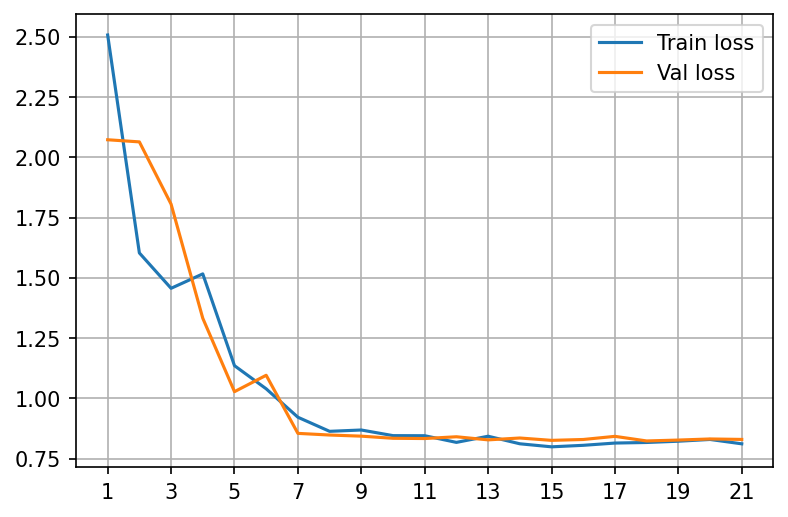

In [52]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots()

for axis in [ax.xaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label='Train loss')
ax.plot(range(1, len(train_loss_list)+1), test_loss_list, label='Val loss')
ax.set_xticks(range(1, len(train_loss_list)+1)[::2])
ax.grid()
ax.legend()
plt.show()

## Загрузка наилучшей модели

In [9]:
model = torch.load('models/trainedFPNModel.pt')

## Проверка обученной модели на тестовом наборе не участвующем в процессе обучения (целевая и полученная разметки наложенны на входное изображение)

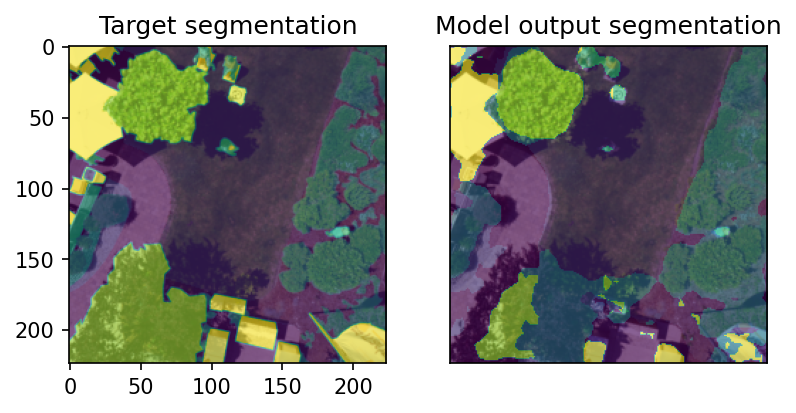

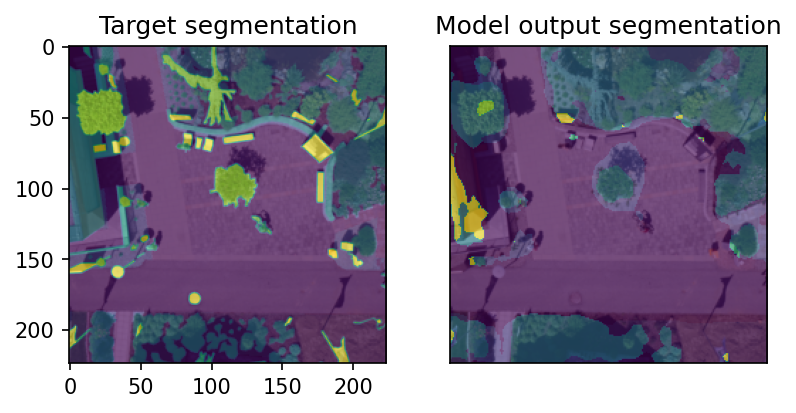

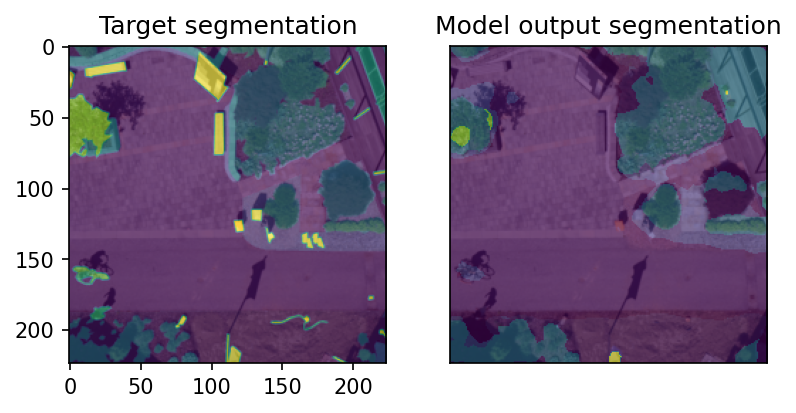

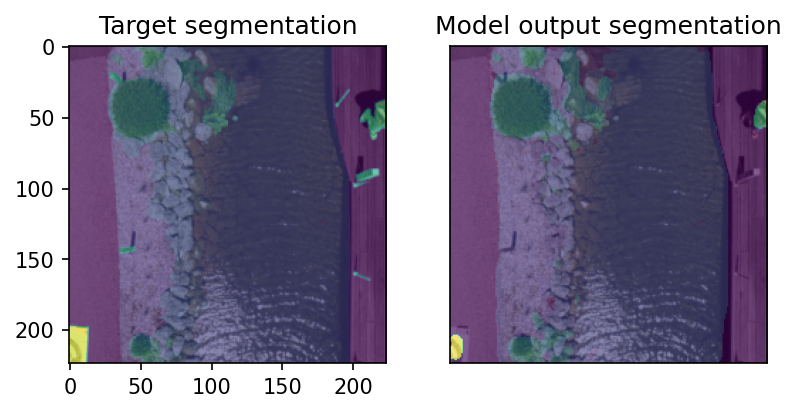

In [58]:
mpl.rcParams['figure.dpi'] = 150

test_features, test_labels = next(iter(testDataLoader))
test_features, test_labels = dataset.getImgsTensors(test_features, test_labels)

test_features = test_features.to(device)
test_labels = test_labels.to(device)

model.eval()
# outputs = model(test_features)['out']
outputs = model(test_features)
outputs = torch.argmax(outputs.squeeze(), dim=1).detach()


rgbImg = cv2.cvtColor(test_features[0, :].cpu().permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2)

axs[0].set_title('Target segmentation')
axs[0].imshow(rgbImg)
axs[0].imshow((test_labels[0][0]).cpu(), alpha=0.6)

axs[1].set_title('Model output segmentation')
axs[1].imshow(rgbImg)
axs[1].imshow(outputs[0].cpu(), alpha=0.6)
plt.xticks([])
plt.yticks([])
plt.show()


rgbImg = cv2.cvtColor(test_features[1, :].cpu().permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2)

axs[0].set_title('Target segmentation')
axs[0].imshow(rgbImg)
axs[0].imshow((test_labels[1][0]).cpu(), alpha=0.6)

axs[1].set_title('Model output segmentation')
axs[1].imshow(rgbImg)
axs[1].imshow(outputs[1].cpu(), alpha=0.6)
plt.xticks([])
plt.yticks([])
plt.show()


rgbImg = cv2.cvtColor(test_features[2, :].cpu().permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2)

axs[0].set_title('Target segmentation')
axs[0].imshow(rgbImg)
axs[0].imshow((test_labels[2][0]).cpu(), alpha=0.6)

axs[1].set_title('Model output segmentation')
axs[1].imshow(rgbImg)
axs[1].imshow(outputs[2].cpu(), alpha=0.6)
plt.xticks([])
plt.yticks([])
plt.show()


rgbImg = cv2.cvtColor(test_features[3, :].cpu().permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2)

axs[0].set_title('Target segmentation')
axs[0].imshow(rgbImg)
axs[0].imshow((test_labels[3][0]).cpu(), alpha=0.6)

axs[1].set_title('Model output segmentation')
axs[1].imshow(rgbImg)
axs[1].imshow(outputs[3].cpu(), alpha=0.6)
plt.xticks([])
plt.yticks([])
plt.show()